In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns


In [31]:
file_paths = [
    'C:/Users/daral/OneDrive - Atlantic TU/year 4/Gesture UI/project1/peugeot_207_02.csv',
    'C:/Users/daral/OneDrive - Atlantic TU/year 4/Gesture UI/project1/peugeot_207_01.csv',
    'C:/Users/daral/OneDrive - Atlantic TU/year 4/Gesture UI/project1/opel_corsa_01.csv',
    'C:/Users/daral/OneDrive - Atlantic TU/year 4/Gesture UI/project1/opel_corsa_02.csv',
    ]

# Function to get the columns of a CSV file
def get_columns(file_path):
    return pd.read_csv(file_path, delimiter=';', encoding='latin1', nrows=0)

# Dictionary to hold file paths and their respective columns
file_columns = {file_path: get_columns(file_path).columns.tolist() for file_path in file_paths}

In [32]:
# Extract the columns of the first file to use as a reference
reference_columns = file_columns[file_paths[0]]

# Function to compare two lists
def lists_match(list1, list2):
    return list1 == list2

# Check if all files have the same structure
all_match = all(lists_match(reference_columns, cols) for cols in file_columns.values())

print(f"All files have the same structure: {all_match}")


All files have the same structure: True


In [33]:
# concatenate all CSV files into a single DataFrame
def concatenate_csv_files(file_paths):
    dfs = []  # List to store DataFrames
    for file_path in file_paths:
        df = pd.read_csv(file_path, delimiter=';', encoding='latin1')  # Load each file into a DataFrame
        dfs.append(df)  # Append the DataFrame to the list
    combined_df = pd.concat(dfs, ignore_index=True)  # Concatenate all DataFrames
    return combined_df

# concatenate all your files
combined_df = concatenate_csv_files(file_paths)

#  inspect the combined DataFrame
print(combined_df.head())  # Print the first 5 rows of the combined dataframe

   Unnamed: 0  AltitudeVariation  VehicleSpeedInstantaneous  \
0          59          -0.599998                  24.299999   
1          60           0.099998                  27.900000   
2          61          -0.200001                  30.599998   
3          62          -0.899998                  29.699999   
4          63          -0.900002                  28.799999   

   VehicleSpeedAverage  VehicleSpeedVariance  VehicleSpeedVariation  \
0             8.720689             46.843772               6.299999   
1             9.045762             52.270798               3.600000   
2             9.405000             59.127937               2.699999   
3             9.900000             64.360674              -0.900000   
4            10.380000             68.519589              -0.900000   

   LongitudinalAcceleration  EngineLoad  EngineCoolantTemperature  \
0                   -1.2903   67.058823                      26.0   
1                   -1.4038    0.000000                 

This method helps identify columns with missing values and gives you an insight into the datatypes of each column.


In [41]:
combined_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23775 entries, 0 to 23774
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 23775 non-null  int64  
 1   AltitudeVariation          23775 non-null  float64
 2   VehicleSpeedInstantaneous  23766 non-null  float64
 3   VehicleSpeedAverage        23775 non-null  float64
 4   VehicleSpeedVariance       23775 non-null  float64
 5   VehicleSpeedVariation      23775 non-null  float64
 6   LongitudinalAcceleration   23775 non-null  float64
 7   EngineLoad                 23770 non-null  float64
 8   EngineCoolantTemperature   23770 non-null  float64
 9   ManifoldAbsolutePressure   23770 non-null  float64
 10  EngineRPM                  23770 non-null  float64
 11  MassAirFlow                23770 non-null  float64
 12  IntakeAirTemperature       23770 non-null  float64
 13  VerticalAcceleration       23775 non-null  flo

The .describe() method shows a quick statistic summary of your numerical data.

In [39]:
combined_df.describe()


,Unnamed: 0,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage
count,23775.000000,23775.000000,23766.000000,23775.000000,23775.000000,23775.000000,23775.000000,23770.000000,23770.000000,23770.000000,23770.000000,23770.000000,23770.000000,23775.000000,23770.000000
mean,3410.669106,-0.263008,38.644538,38.811064,171.920888,-0.020554,0.681683,36.762356,70.818721,115.195120,1486.820257,16.045632,23.483004,0.463398,15.171096
std,2196.419996,2.091264,33.864438,31.149198,182.751192,2.475485,1.582911,26.640593,15.685020,20.455268,578.064539,9.692254,10.902487,3.462745,4.603774
min,44.000000,-24.600006,0.000000,0.000000,0.000000,-103.500000,-3.065000,0.000000,12.000000,88.000000,0.000000,0.880000,7.000000,-2.763100,7.271883
25%,1608.000000,-1.399996,11.700000,15.991532,46.048954,-0.900001,-0.219000,18.823530,63.000000,102.000000,854.000000,6.970000,16.000000,-0.554000,11.672288
50%,3150.000000,-0.099998,31.500000,29.314682,113.907731,0.000000,0.391000,31.372549,79.000000,107.000000,1485.000000,15.360000,19.000000,-0.078100,14.520122
75%,4906.500000,0.700001,54.899998,50.148162,230.200656,0.900002,1.159700,58.431374,81.000000,120.000000,1955.875000,21.717499,31.000000,0.237250,18.288337
max,8613.000000,11.400002,124.749725,121.330733,1418.370369,97.199997,8.477800,100.000000,89.000000,252.000000,3167.000000,73.250000,65.000000,17.944800,45.336861


In [44]:
print(combined_df['Unnamed: 0'].head())


0    59
1    60
2    61
3    62
4    63
Name: Unnamed: 0, dtype: int64


In [43]:
combined_df['drivingStyle'].value_counts()

drivingStyle
EvenPaceStyle      21016
AggressiveStyle     2759
Name: count, dtype: int64

drop rows with any missing values:

In [45]:
def check_first_index(file_path):
    df_temp = pd.read_csv(file_path, delimiter=';', encoding='latin1', nrows=1)
    first_index = df_temp.iloc[0]['Unnamed: 0']
    return first_index


In [46]:
file_paths = [
    'C:/Users/daral/OneDrive - Atlantic TU/year 4/Gesture UI/project1/peugeot_207_02.csv',
    'C:/Users/daral/OneDrive - Atlantic TU/year 4/Gesture UI/project1/peugeot_207_01.csv',
    'C:/Users/daral/OneDrive - Atlantic TU/year 4/Gesture UI/project1/opel_corsa_01.csv',
    'C:/Users/daral/OneDrive - Atlantic TU/year 4/Gesture UI/project1/opel_corsa_02.csv',
]

# Check and print the first index of each file
for file_path in file_paths:
    first_index = check_first_index(file_path)
    print(f"First index in {file_path.split('/')[-1]}: {first_index}")


First index in peugeot_207_02.csv: 59
First index in peugeot_207_01.csv: 59
First index in opel_corsa_01.csv: 59
First index in opel_corsa_02.csv: 44


In [47]:
is_unique = combined_df['Unnamed: 0'].is_unique
print(f"'Unnamed: 0' column is unique: {is_unique}")


'Unnamed: 0' column is unique: False


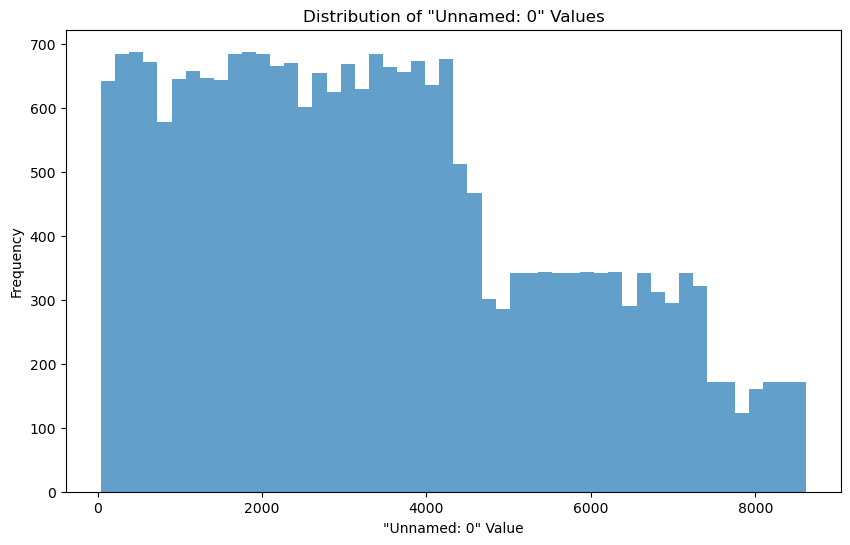

In [48]:
# Example: Plotting the distribution of 'Unnamed: 0' values
plt.figure(figsize=(10, 6))
plt.hist(combined_df['Unnamed: 0'], bins=50, alpha=0.7)
plt.title('Distribution of "Unnamed: 0" Values')
plt.xlabel('"Unnamed: 0" Value')
plt.ylabel('Frequency')
plt.show()


In [50]:
numeric_df = combined_df.select_dtypes(include=[np.number])  # This selects only the numeric columns
correlation_matrix = numeric_df.corr()
print(correlation_matrix['Unnamed: 0'])


Unnamed: 0                   1.000000
AltitudeVariation           -0.057173
VehicleSpeedInstantaneous    0.182689
VehicleSpeedAverage          0.199651
VehicleSpeedVariance         0.014199
VehicleSpeedVariation       -0.006077
LongitudinalAcceleration    -0.135014
EngineLoad                   0.050028
EngineCoolantTemperature     0.099476
ManifoldAbsolutePressure     0.096873
EngineRPM                    0.138630
MassAirFlow                  0.131978
IntakeAirTemperature         0.175893
VerticalAcceleration        -0.236292
FuelConsumptionAverage      -0.229560
Name: Unnamed: 0, dtype: float64


In [53]:
from scipy.stats import chi2_contingency

# Assuming 'roadSurface' is a categorical variable
contingency_table = pd.crosstab(combined_df['Unnamed: 0'], combined_df['drivingStyle'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared test statistic: {chi2}")
print(f"P-value: {p}")


Chi-squared test statistic: 7539.629739312686
P-value: 0.9999999999999949


In [55]:
# Calculate the percentage of missing values for each column
missing_percentages = combined_df.isnull().mean() * 100

# Display the percentage of missing values for each column
print(missing_percentages)

# Set a threshold for acceptable missing percentage
threshold = 5  # For example, 5%

# Find columns with a missing percentage above the threshold
columns_to_consider = missing_percentages[missing_percentages > threshold].index.tolist()

# Decide action based on the columns found
if columns_to_consider:
    print(f"Columns with more than {threshold}% missing values:", columns_to_consider)
    # You might drop these columns, or consider imputing their missing values
else:
    print(f"No columns have more than {threshold}% missing values.")


Unnamed: 0                   0.000000
AltitudeVariation            0.000000
VehicleSpeedInstantaneous    0.037855
VehicleSpeedAverage          0.000000
VehicleSpeedVariance         0.000000
VehicleSpeedVariation        0.000000
LongitudinalAcceleration     0.000000
EngineLoad                   0.021030
EngineCoolantTemperature     0.021030
ManifoldAbsolutePressure     0.021030
EngineRPM                    0.021030
MassAirFlow                  0.021030
IntakeAirTemperature         0.021030
VerticalAcceleration         0.000000
FuelConsumptionAverage       0.021030
roadSurface                  0.000000
traffic                      0.000000
drivingStyle                 0.000000
Segment                      0.000000
dtype: float64
No columns have more than 5% missing values.


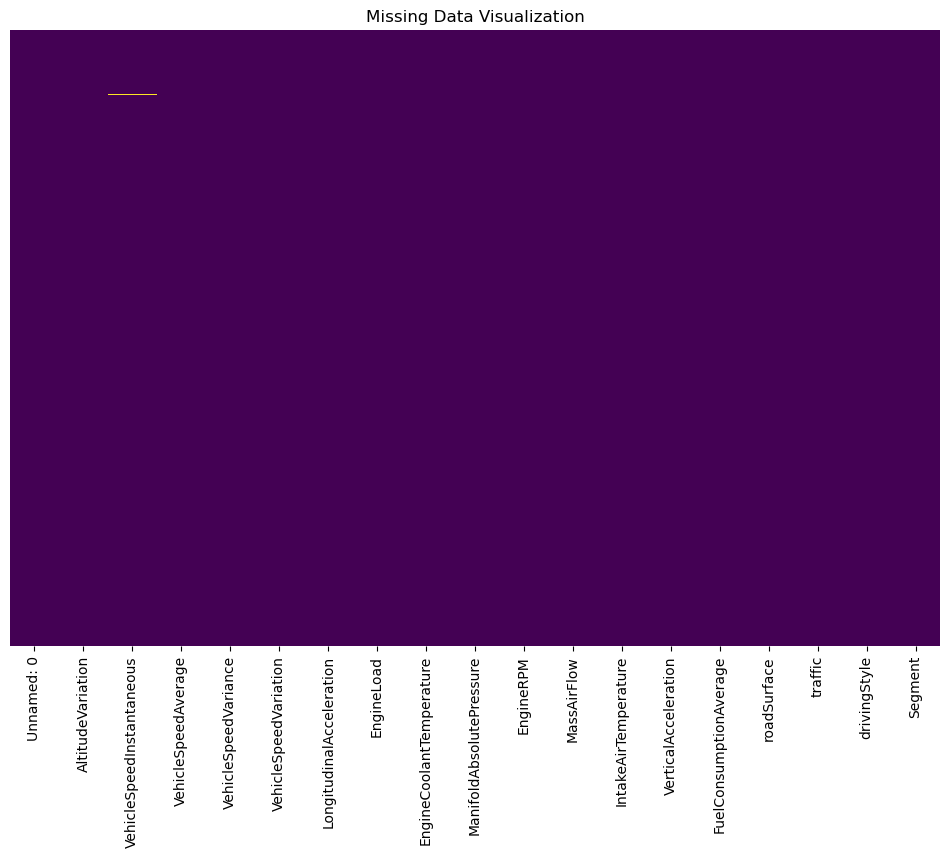

In [56]:
plt.figure(figsize=(12, 8))
sns.heatmap(combined_df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data Visualization')
plt.show()


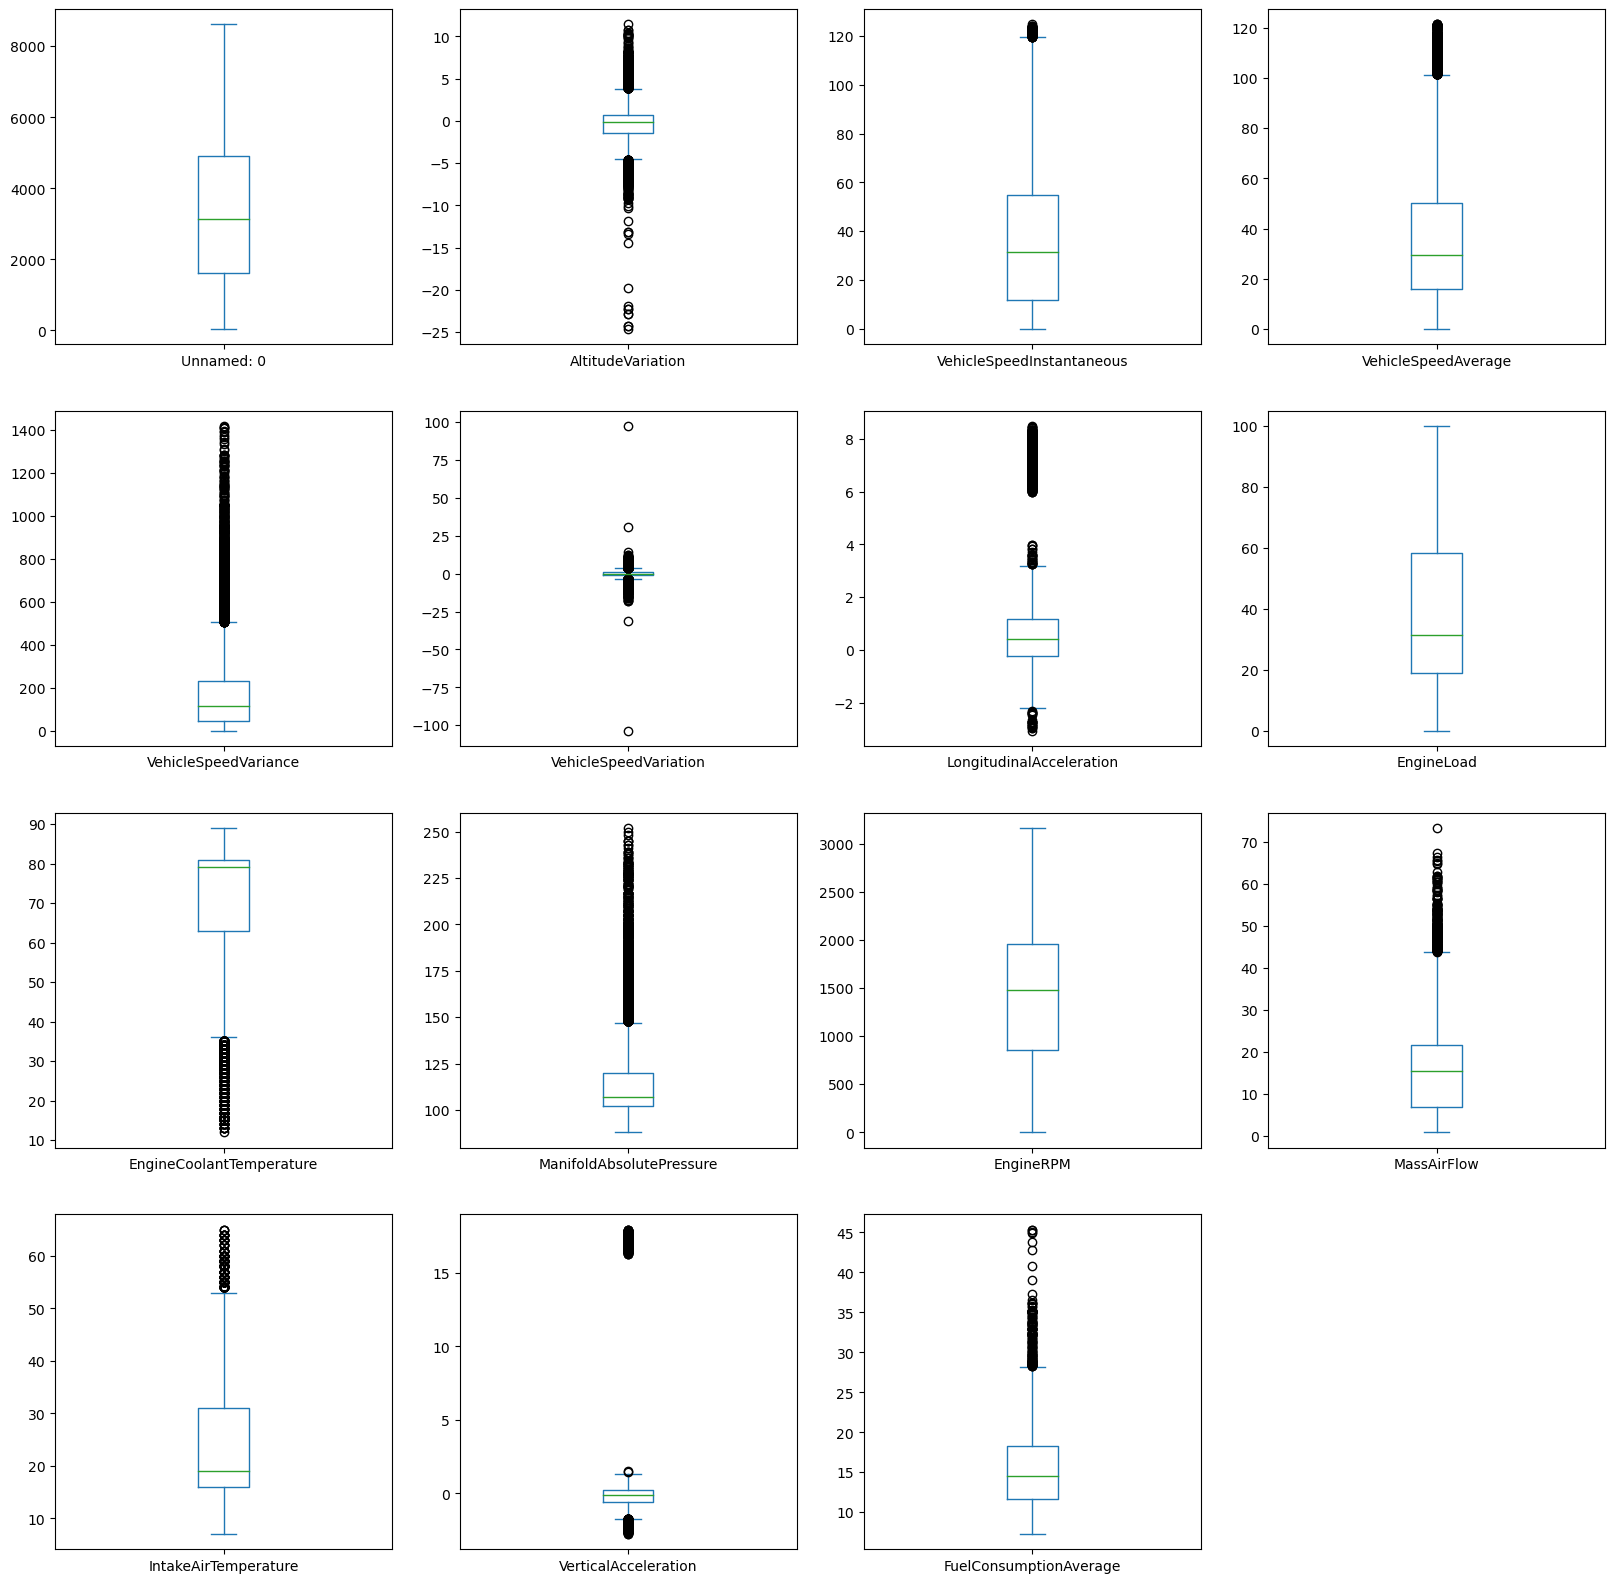

In [57]:
# Box plot for each numerical attribute
numerical_columns = combined_df.select_dtypes(include=[np.number]).columns.tolist()
combined_df[numerical_columns].plot(kind='box', subplots=True, layout=(4,4), figsize=(20, 20))
plt.show()


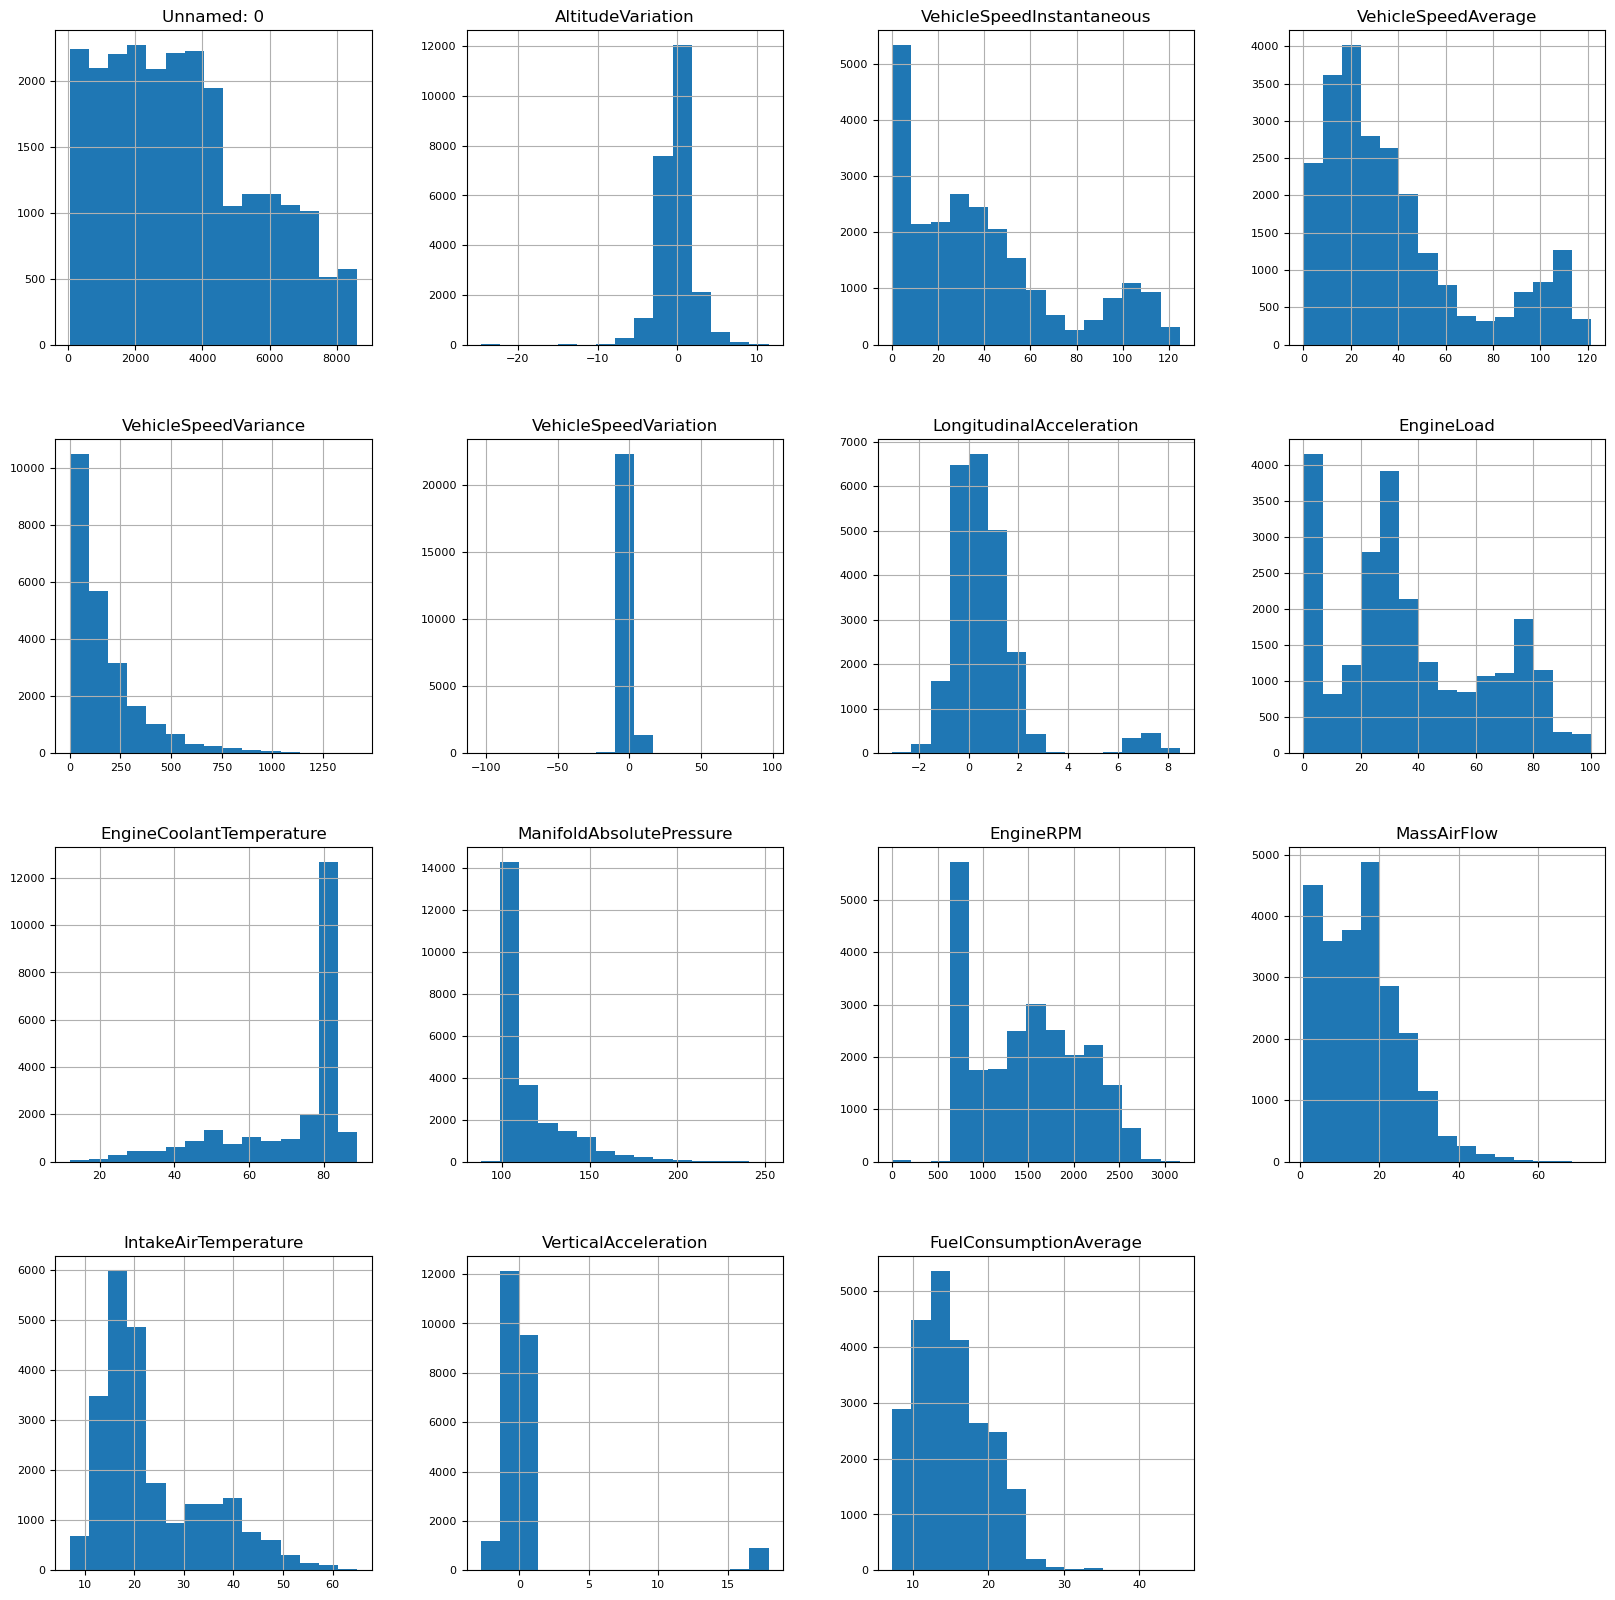

In [58]:
# Histograms for numerical columns
combined_df[numerical_columns].hist(bins=15, figsize=(20, 20), layout=(4, 4), xlabelsize=8, ylabelsize=8)
plt.show()


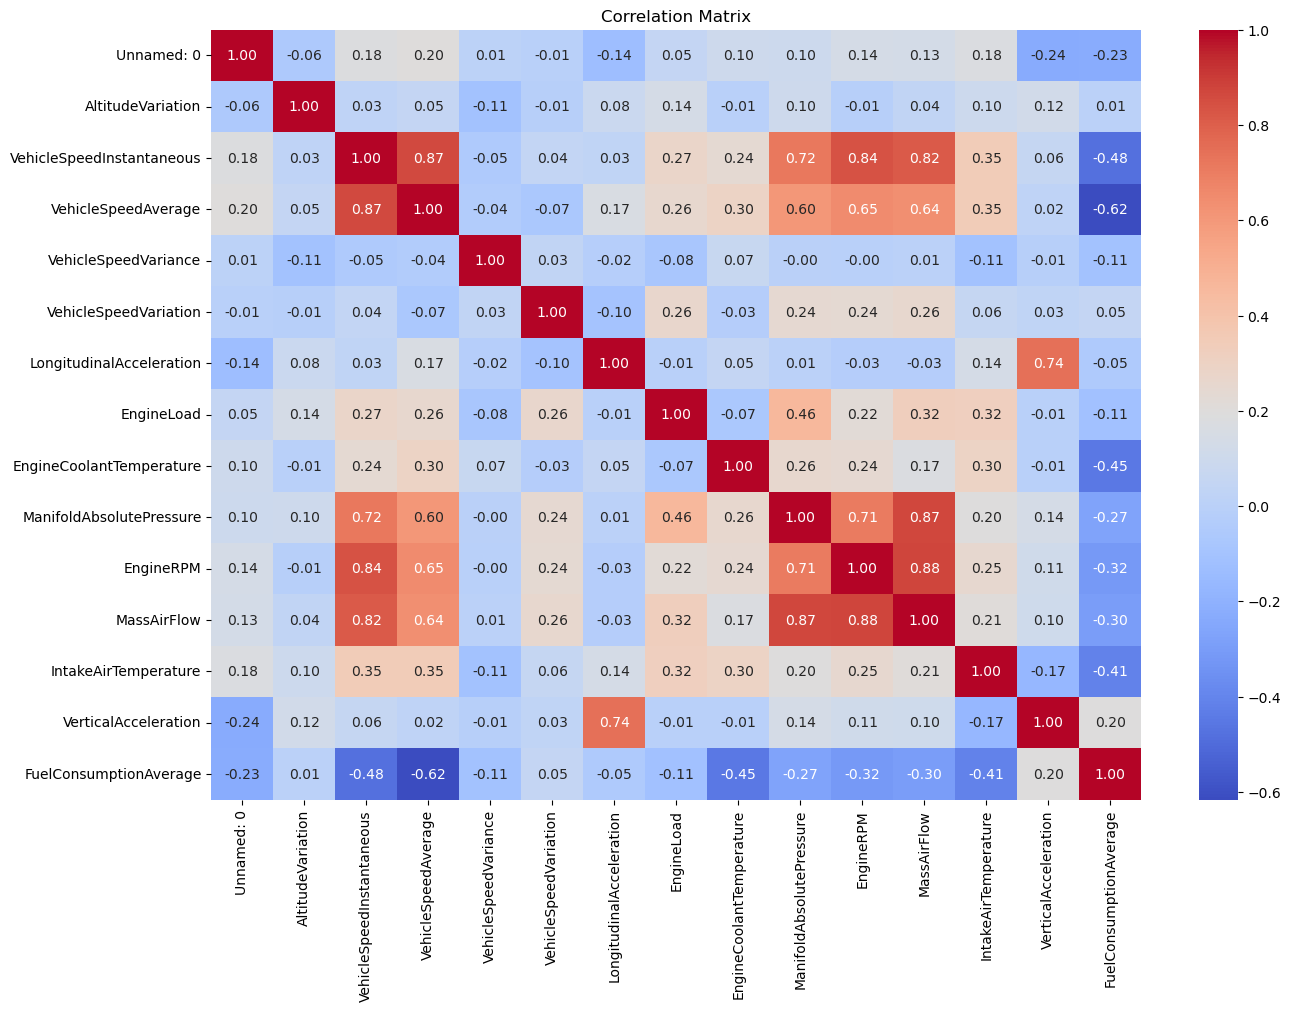

In [63]:
# Select only the numerical columns for the correlation matrix
numerical_df = combined_df.select_dtypes(include=[np.number])

plt.figure(figsize=(15, 10))
# Compute and plot the correlation matrix
sns.heatmap(numerical_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


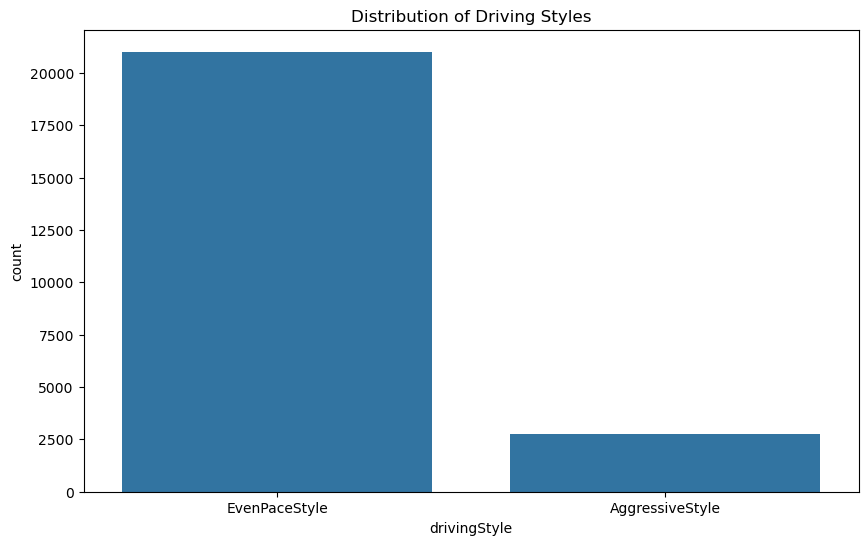

In [60]:
# Example: Count plot for drivingStyle
plt.figure(figsize=(10, 6))
sns.countplot(x='drivingStyle', data=combined_df)
plt.title('Distribution of Driving Styles')
plt.show()


In [61]:
print(f"Number of duplicate records: {combined_df.duplicated().sum()}")

Number of duplicate records: 0


In [62]:
# Assuming 'combined_df' is your pandas DataFrame
categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns
print(categorical_columns)

Index(['roadSurface', 'traffic', 'drivingStyle', 'Segment'], dtype='object')


c:\Users\daral\miniconda3\envs\qiskit-env\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


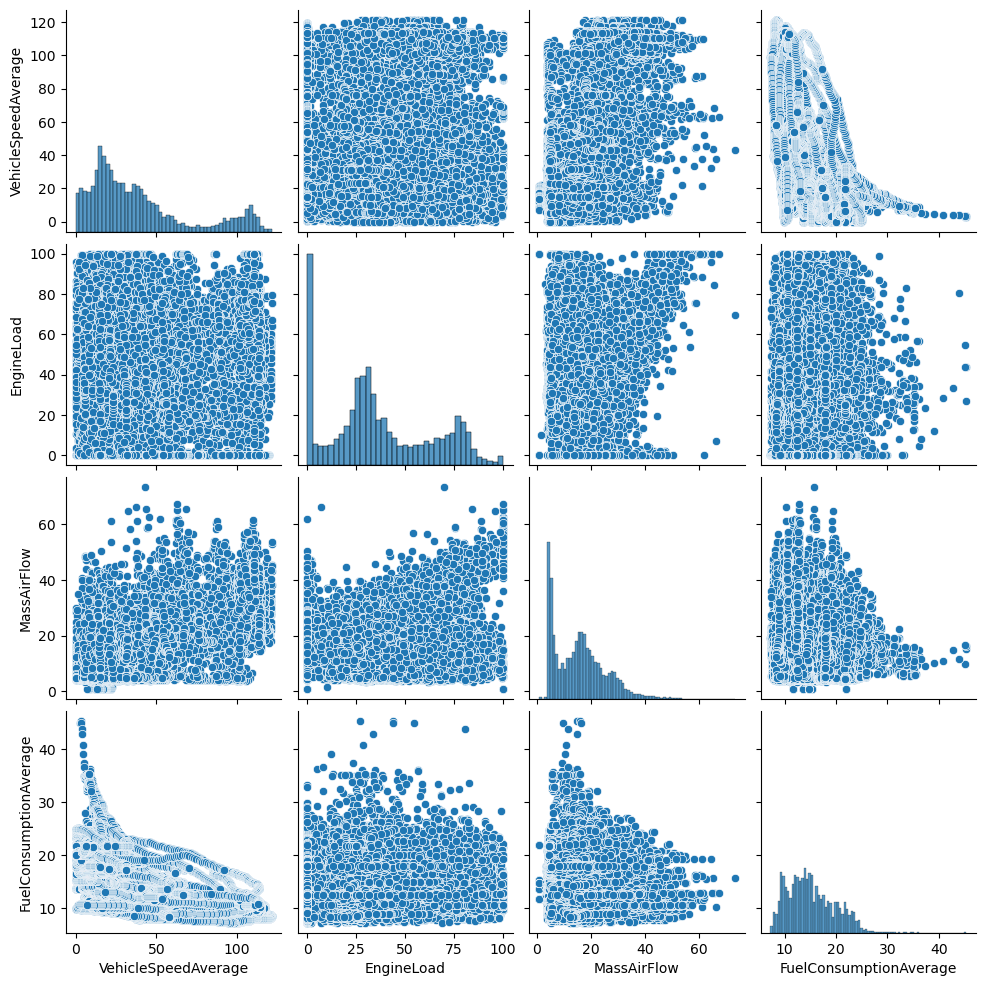

In [64]:
# Select a subset of numerical columns if there are too many to plot all at once
# Here's an example using hypothetical column names. Replace these with your actual column names.
selected_columns = ['VehicleSpeedAverage', 'EngineLoad', 'MassAirFlow', 'FuelConsumptionAverage']

# Now plot the pairplot using seaborn
sns.pairplot(combined_df[selected_columns])
plt.show()

In [65]:
from scipy.stats import chi2_contingency

# Cross-tabulate the two variables
contingency_table = pd.crosstab(combined_df['drivingStyle'], combined_df['roadSurface'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-squared test statistic: {chi2}")
print(f"P-value: {p}")


Chi-squared test statistic: 536.8466742302618
P-value: 2.6621092645635954e-117


In [37]:
# df = df.dropna()


fill missing values with the median of the column:

In [38]:
# df = df.fillna(df.median())